In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from glob import glob
import numpy as np
import healpy as hp
import struct

import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy.io import fits

import pandas as pd
from tqdm import tqdm
import math

import pickle
from matched_clusters import matched_clusters
from matched_clusters_plot import *

from astropy.table import Table
import emcee
import pygtc


In [64]:
import pickle
## Read the saved matched clusters. 
matched_pkl = 'output/' + 'matched_pol100_lgt5_vl50_dsep1000_deltaz0.1.pkl'

with open(matched_pkl, 'rb') as inp:
    matched_cl = pickle.load(inp)

In [65]:
top_match_df = matched_cl.get_match_top_df()

In [66]:
top_match_df.columns

Index(['SPT_ID', 'RA_SPT', 'DEC_SPT', 'xi', 'theta_core', 'Z_SPT',
       'redshift_unc', 'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank',
       'FIELD', 'MEM_MATCH_ID', 'RA_REDM', 'DEC_REDM', 'MODEL_MAG',
       'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ',
       'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z_REDM', 'LAMBDA_CHISQ',
       'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA',
       'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR',
       'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER',
       'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ',
       'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ',
       'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C',
       'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT',
       'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN',
       'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 'P_C', 'BCG_

## Extract parameters 

Quantities needed:
* Z_SPT, 
* xi
* theta_core
* M500c
* beam = 1.3, given 
* propD_sep

Derived quantities include:
* R500c
* theta_500
* x_offset

In [67]:
## converting from M500c to R500c
def Mdelta_to_Rdelta(M_delta, redshift, delta=500, omega_m=0.3089, omega_l=0.6911, omega_b = 0.0486, hubble=0.6774 ):
    aexp = 1./(1.+redshift)
    Ez = np.sqrt(omega_m/aexp**3.0+omega_l)
    fb = omega_b/omega_m
    mu = 0.59
    mue = 1.14
    delta = float(delta)
    erg_to_keV = 624150647.99632

    # critical density of the Universe in Msun/Mpc^3
    rho_crit = (2.77536627e11)*(hubble*Ez)**2.0
    rhohalo = delta * rho_crit # in Msun Mpc^-3
    
    r_delta = (M_delta/(rhohalo)*3/(4*np.pi))**(1/3.)
    return r_delta

In [68]:
##Convert radius to angle
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
#cosmo.arcsec_per_kpc_proper(0.5).value

In [69]:
beam = 1.3 

In [70]:
## Obtain R500c
top_match_df['R500c'] = Mdelta_to_Rdelta(top_match_df['M500']*1e14, top_match_df['Z_SPT'])

In [71]:
## Obtain theta_500
theta_500 = cosmo.arcsec_per_kpc_proper(top_match_df['Z_SPT']).value*top_match_df['R500c']*1000/60 #Convert from kpc2Mpc, from arcsec to arcmin

In [72]:
top_match_df['theta_500'] = theta_500

In [73]:
top_match_df['offset_R500'] = top_match_df.apply(lambda row: (row.propD_sep/1000)/(row.R500c), axis = 1)

In [74]:
top_match_df['offset_R500'].head(5)

0    0.049063
1    0.092840
2    0.143098
3    0.073878
8    0.066092
Name: offset_R500, dtype: float64

## Building the offset model

In [60]:
#Now let's try to write down the likelihood function

def lnlike_fr500(params, offset, theta_core, theta500, xi, beam):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2, kspt = params
   # print(sigma_1);
    #first spt positional uncertainty
    delta_spt = (1.0/xi)*np.sqrt(beam**2.0 + (kspt*theta_core)**2)
    delta_spt = delta_spt/theta500   #now in terms of fraction of r500   #OK.    
   # print(offset)
    
    #next all the pieces of the model
    x = offset
    sigma_0p = np.sqrt(sigma_0**2 + delta_spt**2)
    sigma_1p = np.sqrt(sigma_1**2 + delta_spt**2)
    sigma_2p = np.sqrt(sigma_2**2 + delta_spt**2)

    term1 = (pho_0/(sigma_0p**2))*np.exp(-(x**2)/(2*(sigma_0p**2)))  #matches
    term2 = (pho_1/(sigma_1p**2))*np.exp(-(x**2)/(2*(sigma_1p**2)))  #matches
    term3 = ((1-pho_0-pho_1)/sigma_2p**2)*np.exp(-(x**2)/(2*sigma_2p**2))   #matches
    px = x*(term1 + term2 +term3)
    return np.sum(np.log(px))

In [61]:
#set priors on paramters  
def lnprior_fr500(params):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2, kspt = params
    if \
    pho_0 > 0.00 and \
    pho_1 > 0.00 and \
    pho_0+pho_1 < 1 and \
    0 < sigma_0 < 0.3 and \
    sigma_0 < sigma_1 < 2 and \
    sigma_1 < sigma_2 < 3 and \
    0.5< kspt < 2:
        return 0.0
    return -np.inf

In [62]:
def lnprob_fr500(params, offset, theta_core, theta500, xi, beam):
    lp = lnprior_fr500(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_fr500(params,offset, theta_core,theta500,xi, beam)

## Begin sampling

In [86]:
#let's start the chain the amoeba minimization values
result = [0.6, 0.3, 0.04, 0.1, 0.11, 1.2]
ndim,nwalkers = 6, 100  #debugging
pos = [result + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [87]:
#now try to ru n emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_fr500, args=(top_match_df['offset_R500'], top_match_df['theta_core'], \
                                                                    top_match_df['theta_500'], top_match_df['xi'], beam))

In [88]:
sampler.run_mcmc(pos,3000, progress=True)

100%|██████████| 3000/3000 [16:03<00:00,  3.11it/s]


State([[8.44472881e-01 3.78315406e-02 1.35347822e-02 1.48201260e-01
  4.24318972e-01 1.79331805e+00]
 [8.17227046e-01 1.06020435e-01 4.49154211e-02 5.05048158e-01
  5.98580994e-01 1.77571845e+00]
 [8.91352641e-01 9.27838274e-02 2.92177980e-02 7.38573227e-01
  2.60350972e+00 1.43627537e+00]
 [7.88971016e-01 5.67533987e-02 8.34758397e-03 1.05124591e-01
  4.80434336e-01 1.46269469e+00]
 [7.77546989e-01 1.87140517e-01 2.35224645e-03 4.04385240e-01
  9.79383123e-01 1.39303993e+00]
 [8.16984322e-01 1.79136156e-01 3.52983276e-03 4.67980119e-01
  1.78849547e+00 1.84487306e+00]
 [7.99279738e-01 1.89364784e-01 3.92716696e-03 4.48704575e-01
  5.55356374e-01 1.41578465e+00]
 [8.35291281e-01 5.65876282e-02 9.10835103e-03 3.04946415e-01
  4.69080294e-01 1.25788413e+00]
 [6.85175580e-01 7.94695758e-02 6.72045353e-03 1.60178955e-01
  5.58769704e-01 5.08211713e-01]
 [8.33039964e-01 1.60397566e-01 5.49583836e-02 3.31723309e-01
  7.31375594e-01 8.49834109e-01]
 [7.81356071e-01 8.16786068e-02 9.70739795e-

In [89]:
samples = sampler.chain[:,500:, :].reshape((-1, ndim))

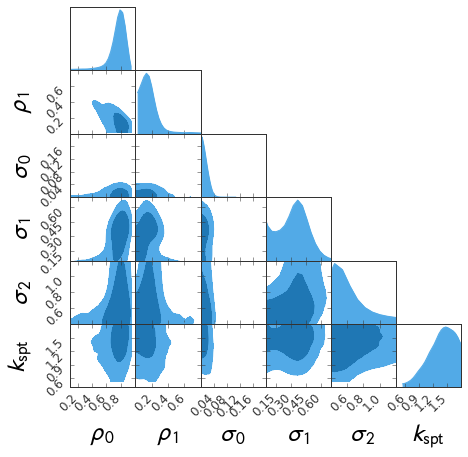

In [93]:
#param_ranges = [[0.3, 1.0],[0., 0.6], [0, 0.06], [0.05, 0.3], [0.3, 1.2], None]
param_ranges = [[0.1, 1.0],[0., 0.8], [0, 0.2], [0.05, 0.7], [.4, 1.2], [0.4,1.8]]
names = [r'$\rho_0$', r'$\rho_1$', "$\sigma_0$","$\sigma_1$", "$\sigma_2$",'$k_\mathrm{spt}$']
fig = pygtc.plotGTC(samples,figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges, plotName='sample_sptpol100d_offset.pdf', 
customLabelFont ={'family':'Arial', 'size':25}, customTickFont ={'family':'Arial', 'size':12} , colorsOrder =['blues']             )


In [95]:
params_fit = np.median(sampler.flatchain, axis=0)

In [96]:
params_fit

array([0.77080574, 0.14361193, 0.01146299, 0.30702736, 0.54037761,
       1.44132366])